/media/3TB/github/Multi-input-Grain-CNN/multiModel.py:242: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(path_model, map_location=device)


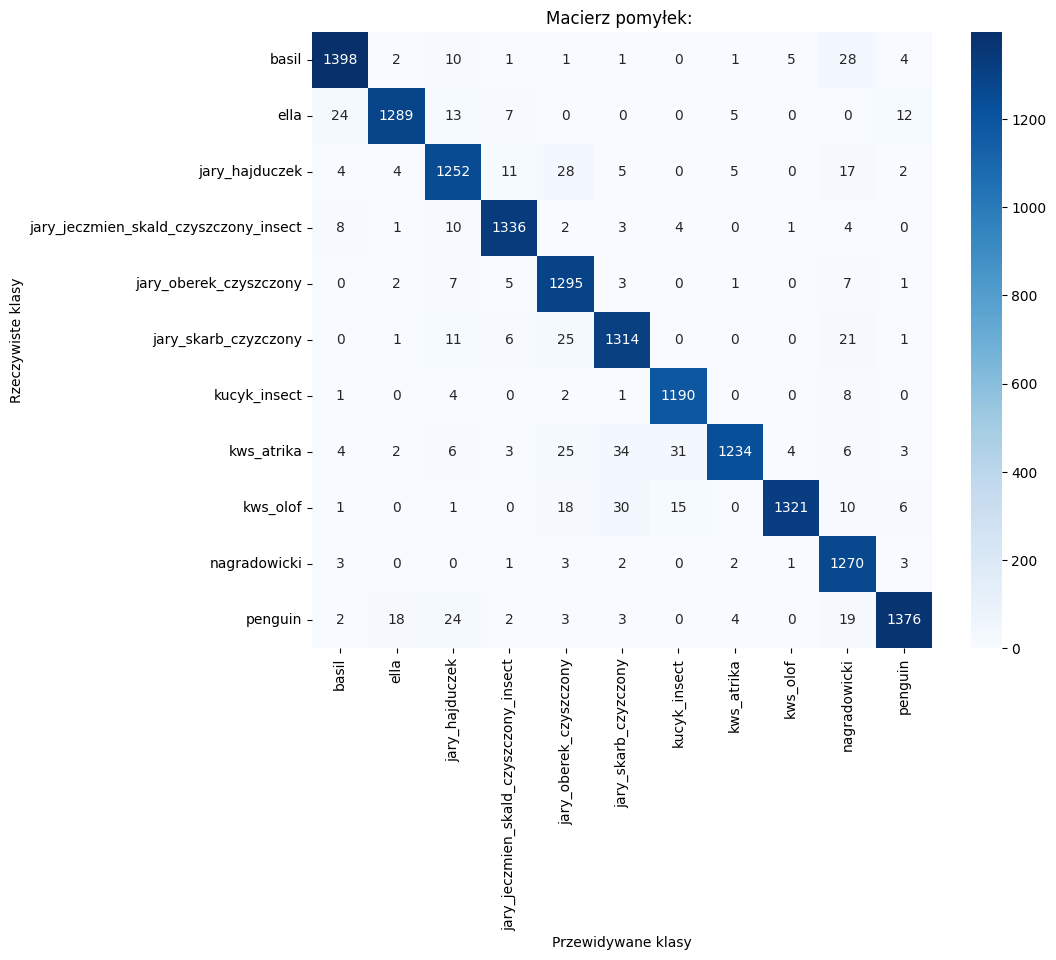

Dokładność: 0.9584

Raport klasyfikacji:
                                       precision    recall  f1-score   support

                                basil       0.97      0.96      0.97      1451
                                 ella       0.98      0.95      0.97      1350
                       jary_hajduczek       0.94      0.94      0.94      1328
jary_jeczmien_skald_czyszczony_insect       0.97      0.98      0.97      1369
               jary_oberek_czyszczony       0.92      0.98      0.95      1321
                 jary_skarb_czyzczony       0.94      0.95      0.95      1379
                         kucyk_insect       0.96      0.99      0.97      1206
                           kws_atrika       0.99      0.91      0.95      1352
                             kws_olof       0.99      0.94      0.97      1402
                         nagradowicki       0.91      0.99      0.95      1285
                              penguin       0.98      0.95      0.96      1451

         

/media/3TB/github/Multi-input-Grain-CNN/multiModel.py:242: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(path_model, map_location=device)


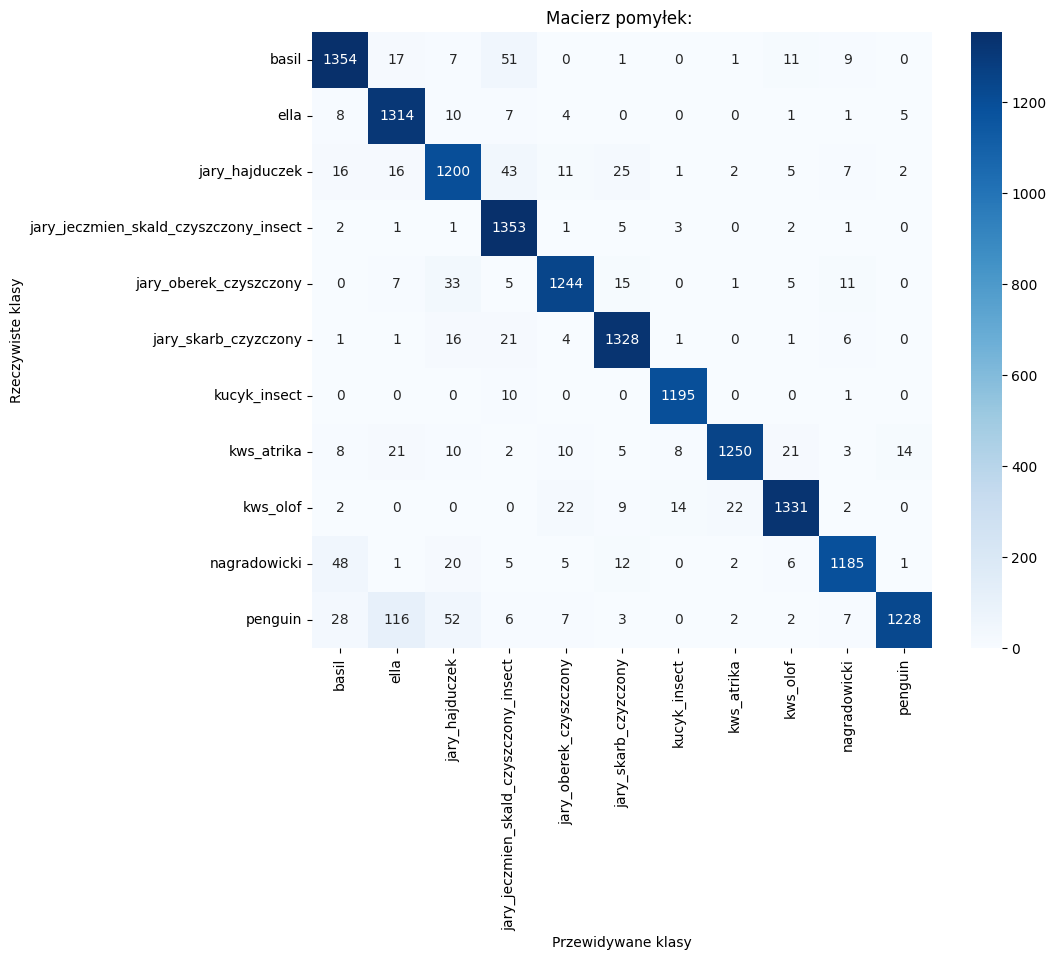

Dokładność: 0.9388

Raport klasyfikacji:
                                       precision    recall  f1-score   support

                                basil       0.92      0.93      0.93      1451
                                 ella       0.88      0.97      0.92      1350
                       jary_hajduczek       0.89      0.90      0.90      1328
jary_jeczmien_skald_czyszczony_insect       0.90      0.99      0.94      1369
               jary_oberek_czyszczony       0.95      0.94      0.95      1321
                 jary_skarb_czyzczony       0.95      0.96      0.95      1379
                         kucyk_insect       0.98      0.99      0.98      1206
                           kws_atrika       0.98      0.92      0.95      1352
                             kws_olof       0.96      0.95      0.96      1402
                         nagradowicki       0.96      0.92      0.94      1285
                              penguin       0.98      0.85      0.91      1451

         

/media/3TB/github/Multi-input-Grain-CNN/multiModel.py:242: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(path_model, map_location=device)


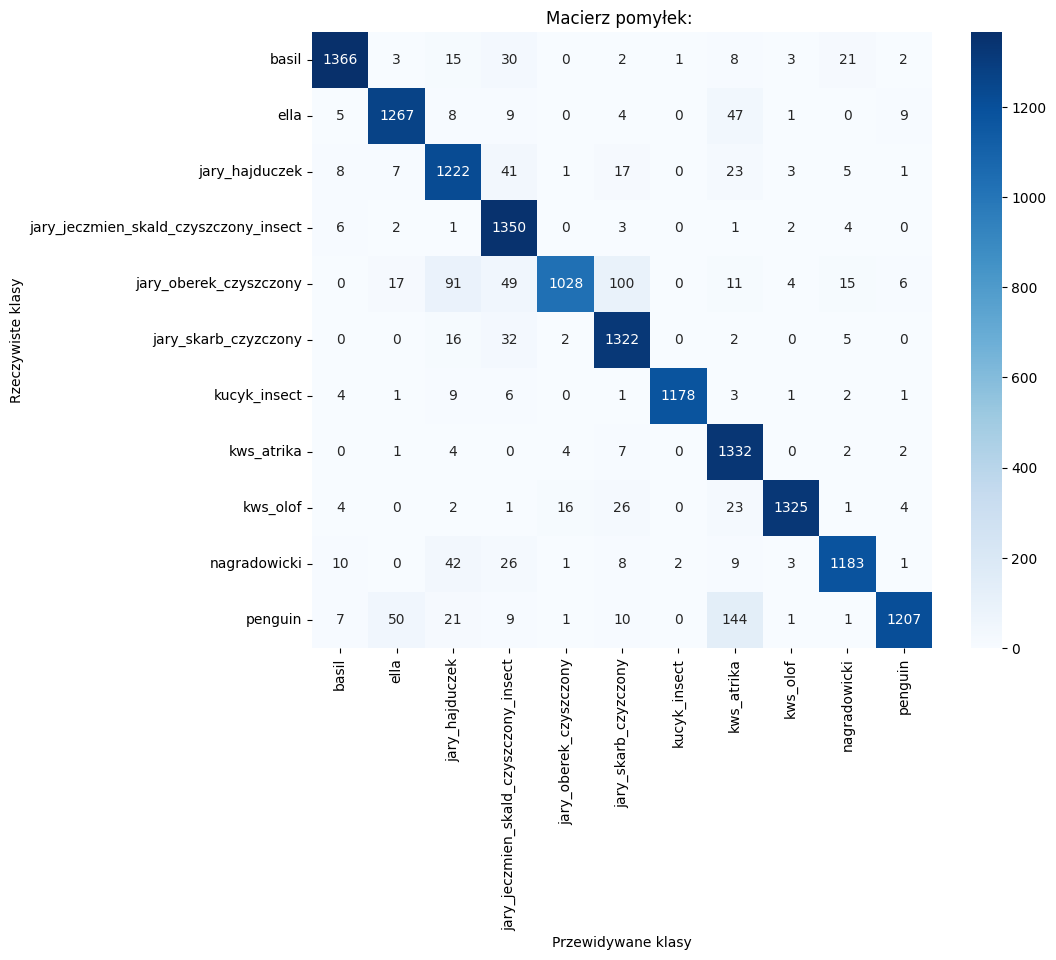

Dokładność: 0.9252

Raport klasyfikacji:
                                       precision    recall  f1-score   support

                                basil       0.97      0.94      0.95      1451
                                 ella       0.94      0.94      0.94      1350
                       jary_hajduczek       0.85      0.92      0.89      1328
jary_jeczmien_skald_czyszczony_insect       0.87      0.99      0.92      1369
               jary_oberek_czyszczony       0.98      0.78      0.87      1321
                 jary_skarb_czyzczony       0.88      0.96      0.92      1379
                         kucyk_insect       1.00      0.98      0.99      1206
                           kws_atrika       0.83      0.99      0.90      1352
                             kws_olof       0.99      0.95      0.97      1402
                         nagradowicki       0.95      0.92      0.94      1285
                              penguin       0.98      0.83      0.90      1451

         

/media/3TB/github/Multi-input-Grain-CNN/multiModel.py:242: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(path_model, map_location=device)


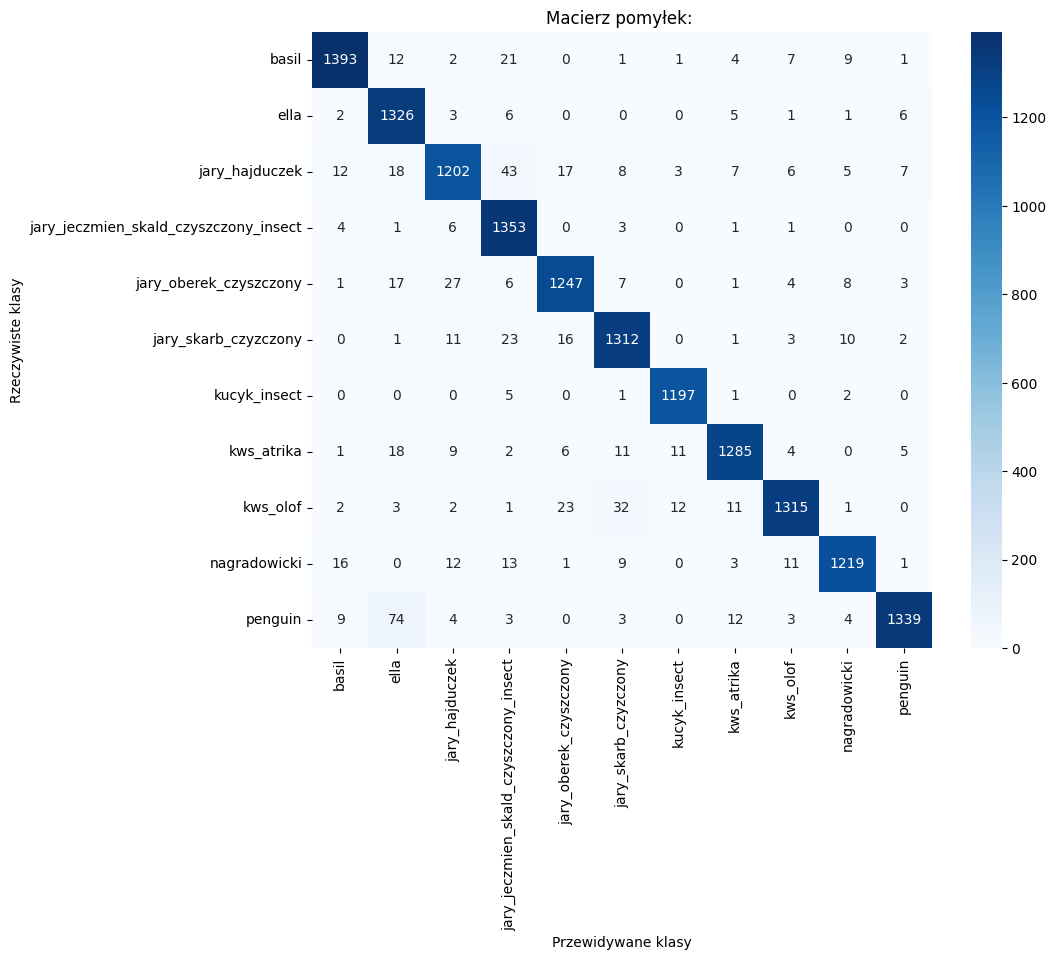

Dokładność: 0.9526

Raport klasyfikacji:
                                       precision    recall  f1-score   support

                                basil       0.97      0.96      0.96      1451
                                 ella       0.90      0.98      0.94      1350
                       jary_hajduczek       0.94      0.91      0.92      1328
jary_jeczmien_skald_czyszczony_insect       0.92      0.99      0.95      1369
               jary_oberek_czyszczony       0.95      0.94      0.95      1321
                 jary_skarb_czyzczony       0.95      0.95      0.95      1379
                         kucyk_insect       0.98      0.99      0.99      1206
                           kws_atrika       0.97      0.95      0.96      1352
                             kws_olof       0.97      0.94      0.95      1402
                         nagradowicki       0.97      0.95      0.96      1285
                              penguin       0.98      0.92      0.95      1451

         

/media/3TB/github/Multi-input-Grain-CNN/multiModel.py:242: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load(path_model, map_location=device)


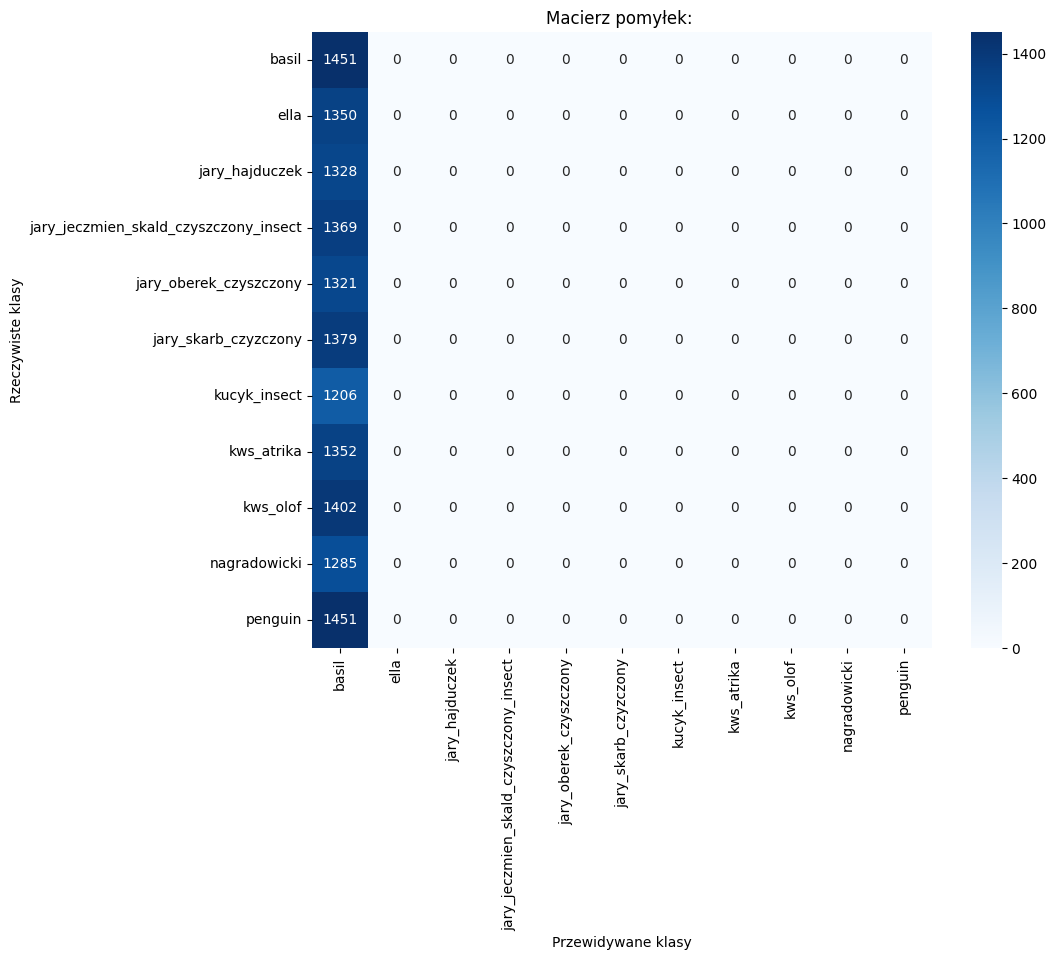

/home/mk/miniconda3/envs/dnn_gpu/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mk/miniconda3/envs/dnn_gpu/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mk/miniconda3/envs/dnn_gpu/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

Dokładność: 0.0974

Raport klasyfikacji:
                                       precision    recall  f1-score   support

                                basil       0.10      1.00      0.18      1451
                                 ella       0.00      0.00      0.00      1350
                       jary_hajduczek       0.00      0.00      0.00      1328
jary_jeczmien_skald_czyszczony_insect       0.00      0.00      0.00      1369
               jary_oberek_czyszczony       0.00      0.00      0.00      1321
                 jary_skarb_czyzczony       0.00      0.00      0.00      1379
                         kucyk_insect       0.00      0.00      0.00      1206
                           kws_atrika       0.00      0.00      0.00      1352
                             kws_olof       0.00      0.00      0.00      1402
                         nagradowicki       0.00      0.00      0.00      1285
                              penguin       0.00      0.00      0.00      1451

         

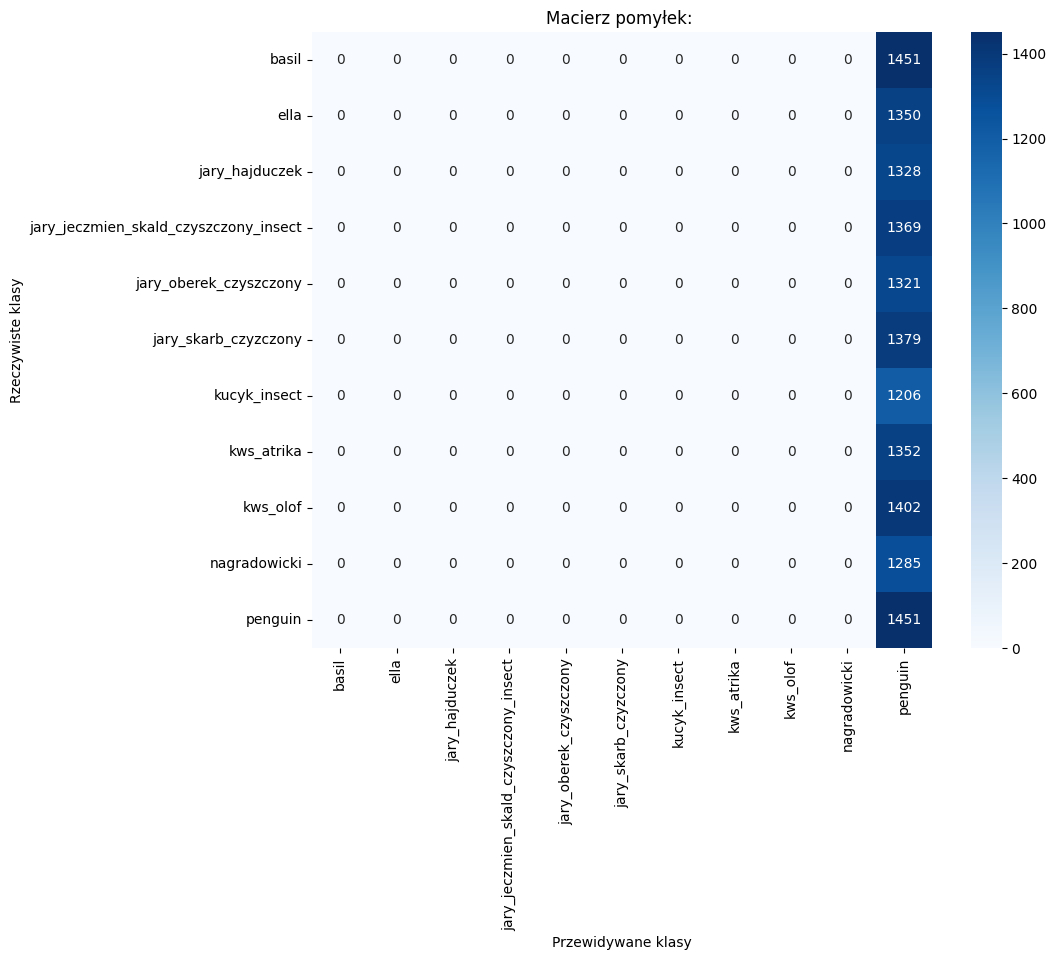

Dokładność: 0.0974

Raport klasyfikacji:
                                       precision    recall  f1-score   support

                                basil       0.00      0.00      0.00      1451
                                 ella       0.00      0.00      0.00      1350
                       jary_hajduczek       0.00      0.00      0.00      1328
jary_jeczmien_skald_czyszczony_insect       0.00      0.00      0.00      1369
               jary_oberek_czyszczony       0.00      0.00      0.00      1321
                 jary_skarb_czyzczony       0.00      0.00      0.00      1379
                         kucyk_insect       0.00      0.00      0.00      1206
                           kws_atrika       0.00      0.00      0.00      1352
                             kws_olof       0.00      0.00      0.00      1402
                         nagradowicki       0.00      0.00      0.00      1285
                              penguin       0.10      1.00      0.18      1451

         

/home/mk/miniconda3/envs/dnn_gpu/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mk/miniconda3/envs/dnn_gpu/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/home/mk/miniconda3/envs/dnn_gpu/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} i

In [1]:
import multiModel as mm
from multiModel import MultiInputModel
from glob import glob
import os
import matplotlib.pyplot as plt
import numpy as np

# Załaduj dane
test_dataset = mm.MultiInputDataset("CSV/dataset/test.csv", transform_rgb=mm.transform_rgb, transform_binary=mm.transform_binary)
test_loader = mm.DataLoader(test_dataset, batch_size=32, shuffle=False)

for path_model in glob("training_results/*.pth"):
    # Wywołanie funkcji testującej
    cm, y_true, y_pred = mm.test_model(
        path_model=path_model,
        test_loader=test_loader,
        device="cuda"
    )

    # Wyświetlenie macierzy pomyłek
    class_names = list(test_dataset.class_to_idx.keys())
    plt.figure(figsize=(10, 8))
    mm.sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
    plt.xlabel("Przewidywane klasy")
    plt.ylabel("Rzeczywiste klasy")
    plt.title(f"Macierz pomyłek: {os.path.split(os.path.basename(path_model))[0]}")
    plt.savefig(os.path.splitext(path_model)[0] + ".png", dpi=300, bbox_inches="tight")
    plt.show()

    # Inne metryki


    # Otwórz plik w trybie zapisu
    with open(os.path.splitext(path_model)[0] + ".txt", "w") as file:
        # Zapisz dokładność
        accuracy = mm.accuracy_score(y_true, y_pred)
        file.write(f"Dokładność: {accuracy:.4f}\n")
        
        # Zapisz raport klasyfikacji
        classification_report = mm.classification_report(y_true, y_pred, target_names=class_names)
        file.write("\nRaport klasyfikacji:\n")
        file.write(classification_report + "\n")
        
        # Zapisz informacje o największej liczbie pomyłek
        off_diagonal = cm - np.diag(np.diag(cm))  # Macierz bez przekątnej
        max_misclassified = np.unravel_index(np.argmax(off_diagonal), off_diagonal.shape)
        
        most_confused_classes = f"Najczęściej mylone klasy: {class_names[max_misclassified[0]]} → {class_names[max_misclassified[1]]}"
        misclassified_count = f"Liczba pomyłek: {off_diagonal[max_misclassified]}"
        
        file.write("\n" + most_confused_classes + "\n")
        file.write(misclassified_count + "\n")
        file.close()

    # Wyświetl w konsoli również, jeśli chcesz
    print(f"Dokładność: {accuracy:.4f}")
    print("\nRaport klasyfikacji:")
    print(classification_report)
    print(most_confused_classes)
    print(misclassified_count)